<a href="https://colab.research.google.com/github/rbbh/Forecasting-Time-Series-with-Algorithm-Ensembling/blob/master/SVR_%2B_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [22]:
from google.colab import files
uploaded = files.upload()

Saving lakeerie.txt to lakeerie.txt


In [0]:
import io
import pandas as pd

# Un-comment the line for the data base that
# you want to predict

#data = pd.read_csv(io.BytesIO(uploaded['airlines2.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['DadosONS.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['carsales.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['coloradoRiver.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['accidentalDeathUSA.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['electric.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['gas.txt']))
data = pd.read_csv(io.BytesIO(uploaded['lakeerie.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['milk.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['redwine.txt']))

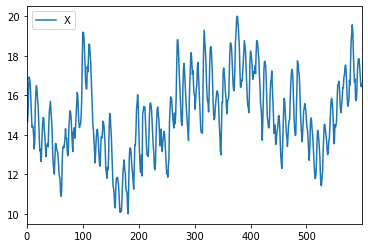

In [24]:
data.plot()


In [25]:
len(data)

600

In [0]:
#Normalizing the data
data_n = data.copy()
data_n = data/data.max()

In [27]:
# TODO: Create function for the Lag used for the prediction
# We will use 12 for the lag dimension if the series repeats 
# itself annually, 3 if it is trimestrial etc.

# Note: For the "ONS" data base, make "dimensions" = 3
# NOTE: For the "Milk" data base, make "dimensions" = 24

dimensions = 12
data_cn = pd.concat([data_n.shift(i) for i in range(0 + dimensions + 1)], axis = 1)

print(data_cn)

           X        X        X        X  ...        X        X        X        X
0    0.73815      NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN
1    0.73245  0.73815      NaN      NaN  ...      NaN      NaN      NaN      NaN
2    0.75425  0.73245  0.73815      NaN  ...      NaN      NaN      NaN      NaN
3    0.81880  0.75425  0.73245  0.73815  ...      NaN      NaN      NaN      NaN
4    0.84630  0.81880  0.75425  0.73245  ...      NaN      NaN      NaN      NaN
..       ...      ...      ...      ...  ...      ...      ...      ...      ...
595  0.87855  0.89280  0.89185  0.87760  ...  0.83300  0.86055  0.91080  0.96015
596  0.85390  0.87855  0.89280  0.89185  ...  0.84155  0.83300  0.86055  0.91080
597  0.83300  0.85390  0.87855  0.89280  ...  0.78845  0.84155  0.83300  0.86055
598  0.82165  0.83300  0.85390  0.87855  ...  0.78655  0.78845  0.84155  0.83300
599  0.82920  0.82165  0.83300  0.85390  ...  0.79980  0.78655  0.78845  0.84155

[600 rows x 13 columns]


In [28]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_cn.iloc[12:,1:]

y = data_cn.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))


118
118
352


In [0]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-3
    max_e = 1e-1
    min_e = 1e-8
    max_g = 1e3
    min_g = 1e-3
    
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles's parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    threshold = 10e100
    
    best_iter = np.zeros(iterations)

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):

        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # To un-normalize the data:
          # Multiply the values by
          # data.to_numpy().max()

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point 
          # is less than prior particle's personal best point,
          # replace personal best
          if(mse < threshold):  
              threshold = mse
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = threshold
              bestRGS = rgs

              # The value below represents the current search coordinates for
              # the current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]
              # Assigning Particle's current best configuration to the Group's best
              g_best = p_best[aux].copy()


        for j in range(n_particles):
            rand1 = np.random.random()
            rand2 = np.random.random()

            # The variable below influences directly the particle's velocity.
            # It can either make it smaller or bigger. 
            w = inertia

            # The equation below represents Particle's velocity, which is
            # the rate of change in its position
            v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

            # Change in the Particle's position 
            c[j] = c[j] + v[j]

            # Below is a series of conditions that stop the particles from
            # leaving the search space
            if(c[j][2] < min_g):
              c[j][2] = min_g
            if(c[j][2] > max_g):
              c[j][2] = max_g
            if(c[j][1] < min_e):
              c[j][1] = min_e
            if(c[j][1] > max_e):
              c[j][1] = max_e
            if(c[j][0] < min_c):
              c[j][0] = min_c
            if(c[j][0] > max_c):
              c[j][0] = max_c
            
     
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
                
        print('Best value iteration # %d = %f\n'%(i, g_best_val))


    # Coordinates found after all the iterations
    print('Group Best configuration found: ')
    print(g_best)
    print('\n')

    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test = bestRGS.predict(X_test)


    # Displaying actual values and predicted values for
    # Group's best configuration found overall
    print(color.BOLD + 'Predictions with the Population Best Value found:\n' + color.END)
    evaluate(predict_test)  
      


In [0]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [0]:
# Function that displays tridimensional plot
def plot(some_list):
 
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

  print('\n')
  print('\n')

In [0]:
def evaluate(predictions):

    from sklearn.metrics import mean_squared_error
    import statistics as st

    predict_test = predictions

    # To un-normalize the data:
    # Multiply the values by
    # data.to_numpy().max()

    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_test, predict_test)
    print('\n')
    print('\n')
    print('Mean Squared Error for the Test Set:\t %f' %mse)
    print('\n')
    print('\n')
    print('Predictions Average:\t %f' %((predict_test.sum()/len(predict_test))))
    print('\n')
    print('\n')
    print('Predictions Median:\t %f' %(st.median(predict_test)))
    print('\n')
    print('\n')

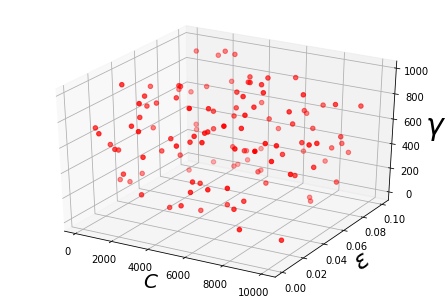





Best value iteration # 0 = 0.002321

Best value iteration # 1 = 0.000448

Best value iteration # 2 = 0.000448

Best value iteration # 3 = 0.000448

Best value iteration # 4 = 0.000448

Best value iteration # 5 = 0.000448

Best value iteration # 6 = 0.000448

Best value iteration # 7 = 0.000445

Best value iteration # 8 = 0.000443

Best value iteration # 9 = 0.000443

Best value iteration # 10 = 0.000443

Best value iteration # 11 = 0.000443

Best value iteration # 12 = 0.000443

Best value iteration # 13 = 0.000443

Best value iteration # 14 = 0.000443

Best value iteration # 15 = 0.000443

Best value iteration # 16 = 0.000441

Best value iteration # 17 = 0.000441

Best value iteration # 18 = 0.000441

Best value iteration # 19 = 0.000441

Best value iteration # 20 = 0.000441

Best value iteration # 21 = 0.000441

Best value iteration # 22 = 0.000441

Best value iteration # 23 = 0.000441

Best value iteration # 24 = 0.000441

Best value iteration # 25 = 0.000441

Best value iterati

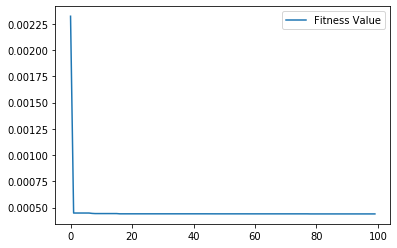

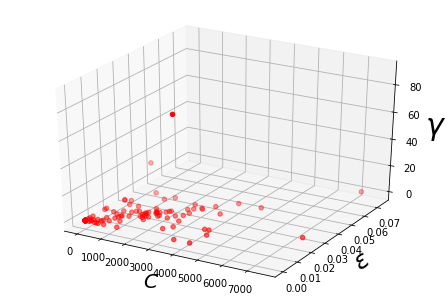





Predictions with the Population Best Value found:



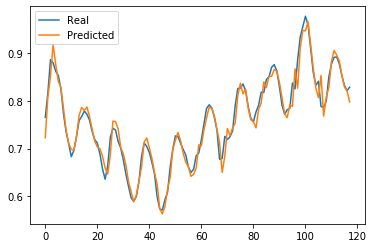





Mean Squared Error for the Test Set:	 0.000368




Predictions Average:	 0.757505




Predictions Median:	 0.757340






In [33]:
pso(120, 100, 3, 1)

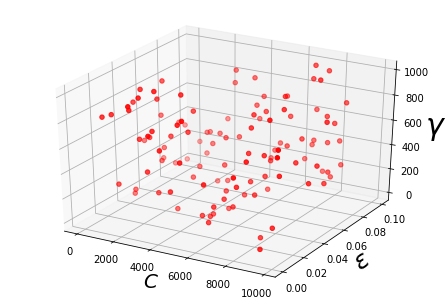





Best value iteration # 0 = 0.001489

Best value iteration # 1 = 0.000451

Best value iteration # 2 = 0.000451

Best value iteration # 3 = 0.000451

Best value iteration # 4 = 0.000443

Best value iteration # 5 = 0.000443

Best value iteration # 6 = 0.000443

Best value iteration # 7 = 0.000443

Best value iteration # 8 = 0.000443

Best value iteration # 9 = 0.000442

Best value iteration # 10 = 0.000442

Best value iteration # 11 = 0.000441

Best value iteration # 12 = 0.000441

Best value iteration # 13 = 0.000441

Best value iteration # 14 = 0.000441

Best value iteration # 15 = 0.000441

Best value iteration # 16 = 0.000441

Best value iteration # 17 = 0.000441

Best value iteration # 18 = 0.000441

Best value iteration # 19 = 0.000441

Best value iteration # 20 = 0.000441

Best value iteration # 21 = 0.000441

Best value iteration # 22 = 0.000441

Best value iteration # 23 = 0.000441

Best value iteration # 24 = 0.000441

Best value iteration # 25 = 0.000440

Best value iterati

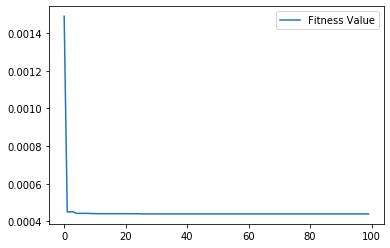

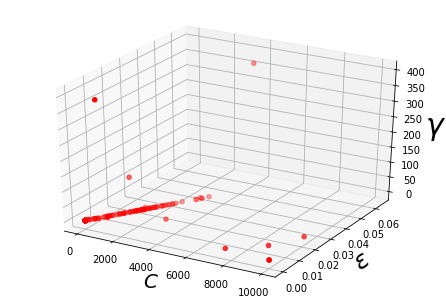





Predictions with the Population Best Value found:



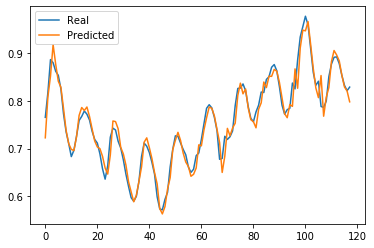





Mean Squared Error for the Test Set:	 0.000369




Predictions Average:	 0.757409




Predictions Median:	 0.757333






In [34]:
pso(120, 100, 3, 0.8)

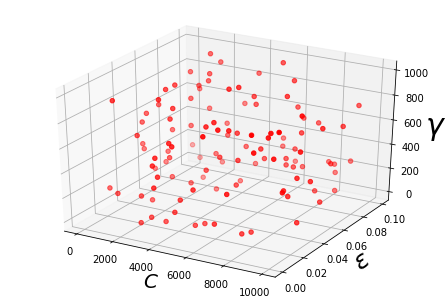





Best value iteration # 0 = 0.001217

Best value iteration # 1 = 0.000462

Best value iteration # 2 = 0.000454

Best value iteration # 3 = 0.000454

Best value iteration # 4 = 0.000445

Best value iteration # 5 = 0.000442

Best value iteration # 6 = 0.000442

Best value iteration # 7 = 0.000442

Best value iteration # 8 = 0.000442

Best value iteration # 9 = 0.000441

Best value iteration # 10 = 0.000440

Best value iteration # 11 = 0.000440

Best value iteration # 12 = 0.000440

Best value iteration # 13 = 0.000440

Best value iteration # 14 = 0.000440

Best value iteration # 15 = 0.000440

Best value iteration # 16 = 0.000440

Best value iteration # 17 = 0.000440

Best value iteration # 18 = 0.000440

Best value iteration # 19 = 0.000440

Best value iteration # 20 = 0.000440

Best value iteration # 21 = 0.000440

Best value iteration # 22 = 0.000440

Best value iteration # 23 = 0.000440

Best value iteration # 24 = 0.000440

Best value iteration # 25 = 0.000440

Best value iterati

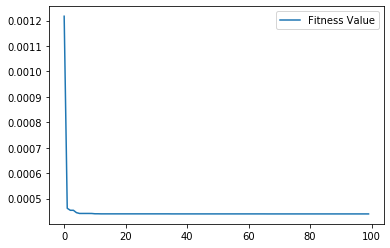

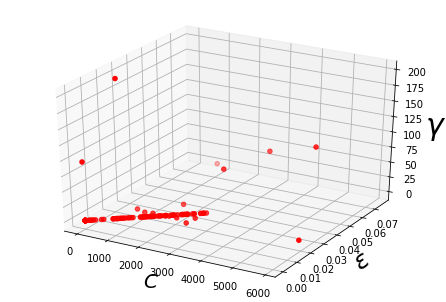





Predictions with the Population Best Value found:



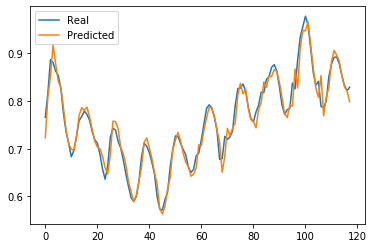





Mean Squared Error for the Test Set:	 0.000366




Predictions Average:	 0.757589




Predictions Median:	 0.757438






In [35]:
pso(120, 100, 3, 0.6)

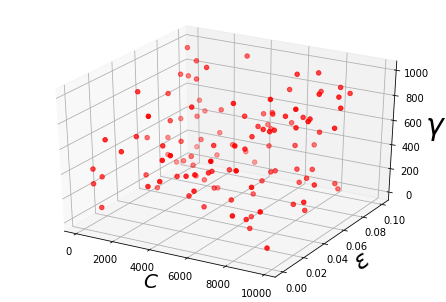





Best value iteration # 0 = 0.001543

Best value iteration # 1 = 0.000450

Best value iteration # 2 = 0.000442

Best value iteration # 3 = 0.000442

Best value iteration # 4 = 0.000442

Best value iteration # 5 = 0.000442

Best value iteration # 6 = 0.000441

Best value iteration # 7 = 0.000441

Best value iteration # 8 = 0.000441

Best value iteration # 9 = 0.000441

Best value iteration # 10 = 0.000440

Best value iteration # 11 = 0.000440

Best value iteration # 12 = 0.000440

Best value iteration # 13 = 0.000440

Best value iteration # 14 = 0.000440

Best value iteration # 15 = 0.000440

Best value iteration # 16 = 0.000440

Best value iteration # 17 = 0.000440

Best value iteration # 18 = 0.000440

Best value iteration # 19 = 0.000440

Best value iteration # 20 = 0.000440

Best value iteration # 21 = 0.000440

Best value iteration # 22 = 0.000440

Best value iteration # 23 = 0.000440

Best value iteration # 24 = 0.000440

Best value iteration # 25 = 0.000440

Best value iterati

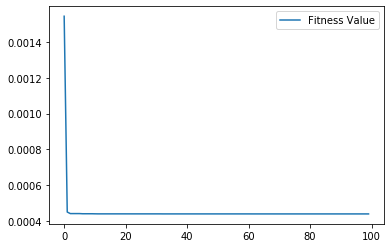

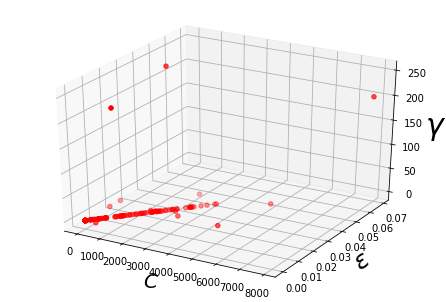





Predictions with the Population Best Value found:



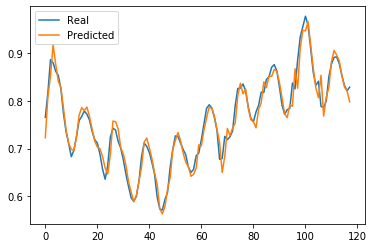





Mean Squared Error for the Test Set:	 0.000368




Predictions Average:	 0.757482




Predictions Median:	 0.757347






In [36]:
pso(120, 100, 3, 0.2)